In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/data
!unzip "/content/drive/MyDrive/X-Ray Validation/data.zip"

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2

In [ ]:
classes = {True: 1, False: 0}
IMG_SIZE = (224,224)

In [ ]:
def load_data():
  DIRECTORY = os.path.join("/content", "data")
  CATEGORY = ['negative','positive']

  images = []
  labels = []

  for category in CATEGORY:
    path = os.path.join(DIRECTORY, category)
    print(f'loading {category}')

    for file in os.listdir(path):
      try:
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)

        images.append(img/255)
        labels.append(1 if category == 'positive' else 0)
      except Exception as e:
        print("Eror Loading File => ",file)

    # output.append((images,labels))
  images = np.array(images, dtype='float32')
  labels = np.array(labels, dtype='int8').reshape((-1,1))
  return (images,labels)

In [ ]:
images, labels = load_data()

loading negative
loading positive
Eror=>  123 (8)2.gif
Eror=>  123 (7)2.gif
Eror=>  123 (6)2.gif


In [ ]:
images.shape
# labels.shape

(2329, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0, stratify=labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(224,224,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), padding='same',  activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.15),    
    Dense(512, activation='relu'),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dropout(0.15),    
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                        

In [ ]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test,y_test))

Epoch 1/30
59/59 [==============================] - 20s 152ms/step - loss: 0.3980 - accuracy: 0.7864 - val_loss: 0.2663 - val_accuracy: 0.9485
Epoch 2/30
59/59 [==============================] - 8s 137ms/step - loss: 0.1259 - accuracy: 0.9624 - val_loss: 0.2410 - val_accuracy: 0.9356
Epoch 3/30
59/59 [==============================] - 7s 126ms/step - loss: 0.1276 - accuracy: 0.9587 - val_loss: 0.2191 - val_accuracy: 0.9764
Epoch 4/30
59/59 [==============================] - 8s 127ms/step - loss: 0.0660 - accuracy: 0.9737 - val_loss: 0.1311 - val_accuracy: 0.9657
Epoch 5/30
59/59 [==============================] - 7s 127ms/step - loss: 0.0588 - accuracy: 0.9828 - val_loss: 0.0612 - val_accuracy: 0.9828
Epoch 6/30
59/59 [==============================] - 7s 127ms/step - loss: 0.0364 - accuracy: 0.9882 - val_loss: 0.0551 - val_accuracy: 0.9828
Epoch 7/30
59/59 [==============================] - 8s 128ms/step - loss: 0.1223 - accuracy: 0.9603 - val_loss: 0.0832 - val_accuracy: 0.9678
Epoch

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def graph(history):
  fig = plt.figure(figsize=(10,5))

  plt.subplot(221)
  plt.plot(history.history['accuracy'], label="acc")
  plt.plot(history.history['val_accuracy'],  label="val_acc")
  plt.title("Training accuracy vs validation accuracy")
  plt.xlabel('accuracy')
  plt.ylabel('epochs')
  plt.legend()
  
  plt.subplot(222)
  plt.plot(history.history['loss'], label="loss")
  plt.plot(history.history['val_loss'], label="val_loss")
  plt.title("Training loss vs validation loss")
  plt.xlabel('loss')
  plt.ylabel('epochs')
  plt.legend()

  plt.show()

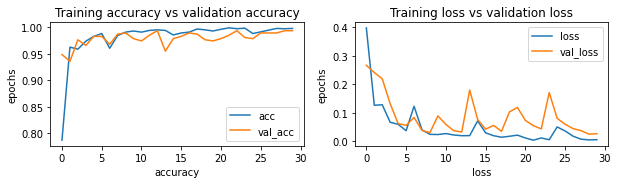

In [ ]:
graph(history)

In [ ]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 47ms/step - loss: 0.0259 - accuracy: 0.9936


[0.025865059345960617, 0.9935622215270996]

In [ ]:
model.save('/content/model.h5')

In [ ]:
!zip -r model.zip model.h5

  adding: model.h5 (deflated 21%)


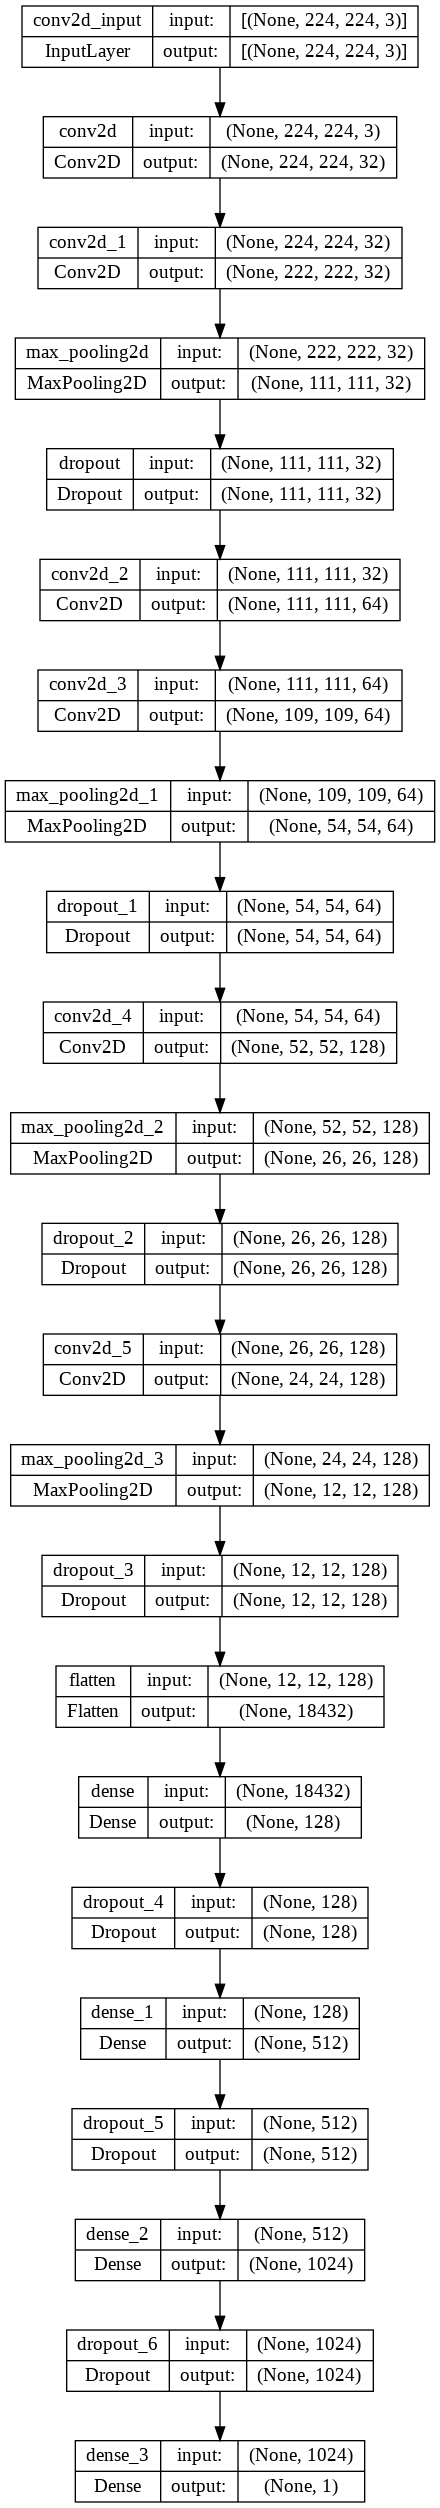

In [ ]:

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
! pip install simplejson
import simplejson

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Saved model to disk


In [ ]:
!zip -r validation.zip model.h5 model.json model.png

  adding: model.h5 (deflated 8%)
  adding: model.json (deflated 95%)
  adding: model.png (deflated 16%)
